In [117]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import GRU



In [118]:
df = pd.read_csv("hmm_probs_K2_diag_lstm_input.csv")
df["date"] = pd.to_datetime(df["date"].str.strip())
df = df.sort_values("date").reset_index(drop=True)
df["delta_spi"] = df["spi_6"] - df["spi_6"].shift(1)
df["spi_trend_4"] = df["spi_6"] - df["spi_6"].shift(4)

In [119]:
df

,date,Last Price,ret_1,spi_6,p_state0_h1,p_state1_h1,p_state0_h4,p_state1_h4,delta_spi,spi_trend_4
0,1992-01-12,2.43,0.016736,-0.676211,0.964554,0.035446,0.883955,0.116045,NaN,NaN
1,1992-01-19,2.48,0.020576,-0.408163,0.955646,0.044354,0.876273,0.123727,0.268048,NaN
2,1992-01-26,2.55,0.028226,-0.149762,0.928400,0.071600,0.852779,0.147221,0.258400,NaN
3,1992-02-02,2.57,0.007843,-0.012210,0.871534,0.128466,0.803744,0.196256,0.137552,NaN
4,1992-02-09,2.57,0.000000,-0.154111,0.874133,0.125867,0.805985,0.194015,-0.141901,0.522099
...,...,...,...,...,...,...,...,...,...,...
1744,2025-06-29,4.00,-0.014778,-0.317970,0.969231,0.030769,0.888888,0.111112,-0.275607,-0.126846
1745,2025-07-06,4.10,0.025000,-0.346593,0.969101,0.030899,0.888778,0.111222,-0.028624,-0.516283
1746,2025-07-13,3.87,-0.056098,-0.113659,0.966651,0.033349,0.886692,0.113308,0.232935,-0.079472
1747,2025-07-20,3.95,0.020672,0.110532,0.960174,0.039826,0.881182,0.118818,0.224191,0.152895


In [120]:
df["y_next"] = df["Last Price"].shift(-1)      # one-step ahead
df["y_4ahead"] = df["Last Price"].shift(-4)    # 4-step ahead

df = df.dropna().reset_index(drop=True)
n = len(df)
train_raw = int(0.80 * n)
val_raw   = int(0.10 * n)

In [121]:
def create_sequences(X, y, lookback=52):
    Xs, ys = [], []
    for i in range(len(X) - lookback):
        Xs.append(X[i:i+lookback])
        ys.append(y[i+lookback])
    return np.array(Xs), np.array(ys)

In [122]:
features_hmm = [
    "Last Price",
    "p_state0_h1"

]


# === FEATURE SCALER (multivariate) ===
scalerX = MinMaxScaler()
scalerX.fit(df[features_hmm].iloc[:train_raw])   # fit on TRAIN only
X_scaled = scalerX.transform(df[features_hmm])

# === TARGET SCALER (price-only) ===
scalerY = MinMaxScaler()
scalerY.fit(df[["Last Price"]].iloc[:train_raw])

y_next_scaled = scalerY.transform(df[["y_next"]].values)
y_4_scaled    = scalerY.transform(df[["y_4ahead"]].values)


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


In [123]:
lookback = 52

Xn, yn = create_sequences(X_scaled, y_next_scaled, lookback)
X4, y4 = create_sequences(X_scaled, y_4_scaled, lookback)
num_features = len(features_hmm)

In [124]:
def build_gru_model(lookback, num_features):
    model = Sequential([
        Input(shape=(lookback, num_features)),
        GRU(64, return_sequences=False),
        Dropout(0.2),
        Dense(32, activation="relu"),
        Dense(1)
    ])

    model.compile(optimizer="adam", loss="mse")
    return model



In [125]:
train_seq_end = train_raw - lookback
val_seq_end   = train_seq_end + val_raw

Xn_train = Xn[:train_seq_end]
yn_train = yn[:train_seq_end]

Xn_val   = Xn[train_seq_end:val_seq_end]
yn_val   = yn[train_seq_end:val_seq_end]

Xn_test  = Xn[val_seq_end:]
yn_test  = yn[val_seq_end:]

# same for 4-week model
X4_train = X4[:train_seq_end]
y4_train = y4[:train_seq_end]

X4_val   = X4[train_seq_end:val_seq_end]
y4_val   = y4[train_seq_end:val_seq_end]

X4_test  = X4[val_seq_end:]
y4_test  = y4[val_seq_end:]


In [126]:
from tensorflow.keras.callbacks import EarlyStopping

es = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)


In [127]:
model_next = build_gru_model(lookback, num_features)
history_next = model_next.fit(
    Xn_train, yn_train,
    validation_data=(Xn_val, yn_val),
    epochs=100,
    batch_size=32,
    callbacks=[es],
    verbose=1
)

model_4 = build_gru_model(lookback, num_features)
history_4 = model_4.fit(
    X4_train, y4_train,
    validation_data=(X4_val, y4_val),
    epochs=100,
    batch_size=32,
    callbacks=[es],
    verbose=1
)

Epoch 1/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 7s 46ms/step - loss: 0.0137 - val_loss: 0.0022
Epoch 2/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.0041 - val_loss: 0.0022
Epoch 3/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0029 - val_loss: 0.0019
Epoch 4/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0029 - val_loss: 0.0021
Epoch 5/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0025 - val_loss: 0.0031
Epoch 6/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - loss: 0.0024 - val_loss: 0.0020
Epoch 7/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0020 - val_loss: 0.0019
Epoch 8/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0022 - val_loss: 0.0020
Epoch 9/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0020 - val_loss: 0.0016
Epoch 10/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0017 - val_loss: 0.0016
Epoch 11/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0018 - val_loss: 0.0021
Epoch 12/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step

In [128]:
pred_next_scaled = model_next.predict(Xn_test)
pred_next = scalerY.inverse_transform(pred_next_scaled)

true_next = scalerY.inverse_transform(yn_test)
pred_4_scaled = model_4.predict(X4_test)
pred_4 = scalerY.inverse_transform(pred_4_scaled)

true_4 = scalerY.inverse_transform(y4_test)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


In [129]:
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

rmse_next = np.sqrt(mean_squared_error(true_next, pred_next))
mape_next = mean_absolute_percentage_error(true_next, pred_next)

rmse_4 = np.sqrt(mean_squared_error(true_4, pred_4))
mape_4 = mean_absolute_percentage_error(true_4, pred_4)

print("Next-week forecast → RMSE:", rmse_next, "MAPE:", mape_next)
print("4-week ahead forecast → RMSE:", rmse_4, "MAPE:", mape_4)

Next-week forecast → RMSE: 0.2689235241411708 MAPE: 0.0369026345591485
4-week ahead forecast → RMSE: 0.4375742645451003 MAPE: 0.06986962916659298


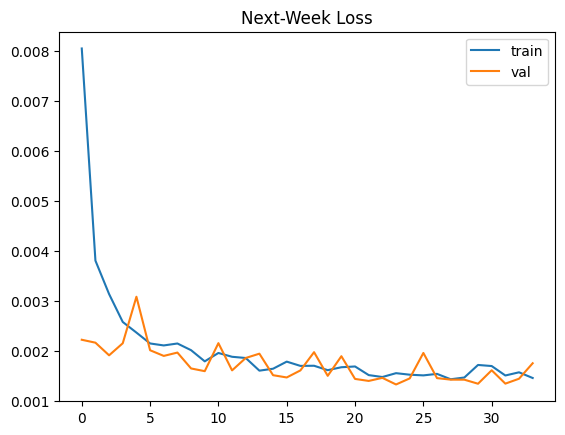

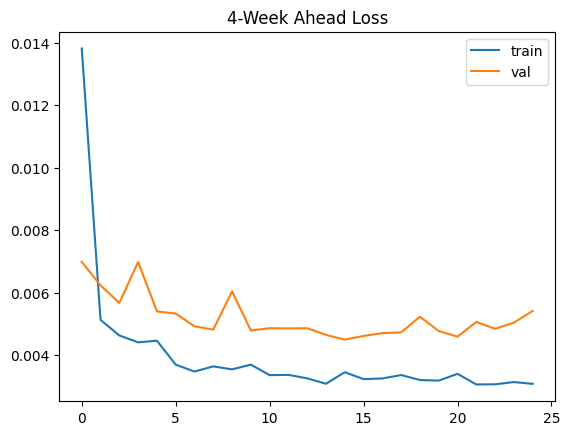

In [130]:
plt.plot(history_next.history["loss"], label="train")
plt.plot(history_next.history["val_loss"], label="val")
plt.title("Next-Week Loss")
plt.legend()
plt.show()

plt.plot(history_4.history["loss"], label="train")
plt.plot(history_4.history["val_loss"], label="val")
plt.title("4-Week Ahead Loss")
plt.legend()
plt.show()

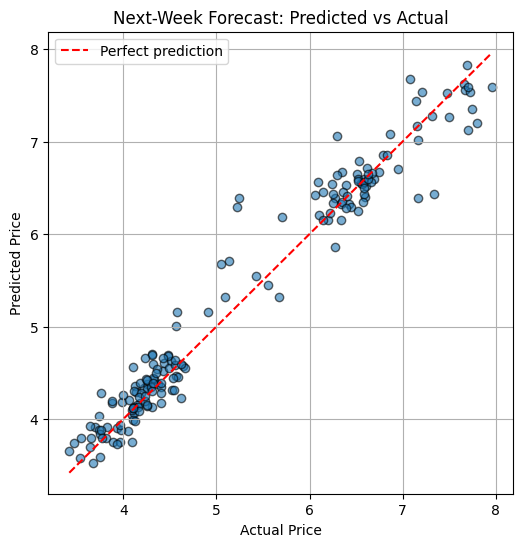

In [131]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,6))
plt.scatter(true_next, pred_next, alpha=0.6, edgecolor='k')

# 45-degree reference line
mn = min(true_next.min(), pred_next.min())
mx = max(true_next.max(), pred_next.max())
plt.plot([mn, mx], [mn, mx], 'r--', label="Perfect prediction")

plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("Next-Week Forecast: Predicted vs Actual")
plt.legend()
plt.grid(True)
plt.show()


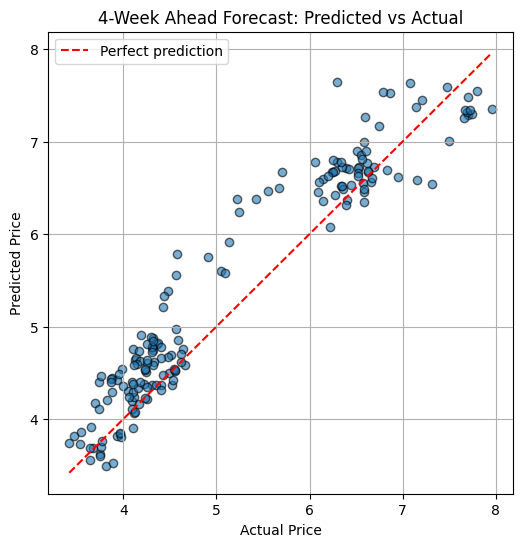

In [132]:
plt.figure(figsize=(6,6))
plt.scatter(true_4, pred_4, alpha=0.6, edgecolor='k')

# 45-degree reference line
mn = min(true_4.min(), pred_4.min())
mx = max(true_4.max(), pred_4.max())
plt.plot([mn, mx], [mn, mx], 'r--', label="Perfect prediction")

plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("4-Week Ahead Forecast: Predicted vs Actual")
plt.legend()
plt.grid(True)
plt.show()


In [133]:
errors_next = (pred_next - true_next).flatten()
errors_4 = (pred_4 - true_4).flatten()

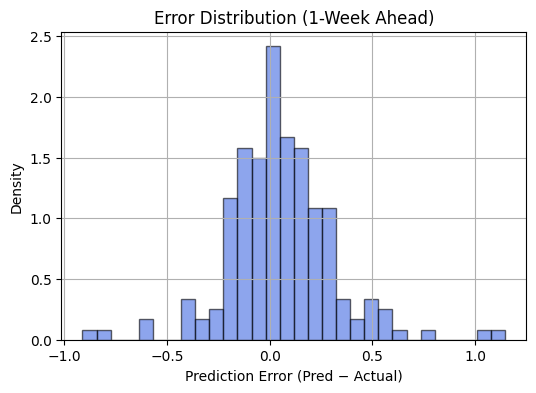

In [134]:
plt.figure(figsize=(6,4))
plt.hist(errors_next, bins=30, density=True, alpha=0.6, color='royalblue', edgecolor='black')
plt.title("Error Distribution (1-Week Ahead)")
plt.xlabel("Prediction Error (Pred − Actual)")
plt.ylabel("Density")
plt.grid(True)
plt.show()

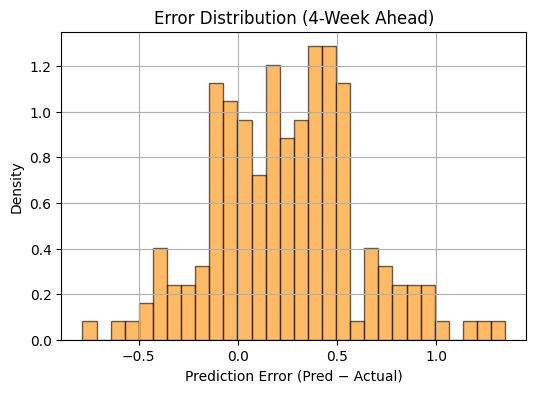

In [135]:
plt.figure(figsize=(6,4))
plt.hist(errors_4, bins=30, density=True, alpha=0.6, color='darkorange', edgecolor='black')
plt.title("Error Distribution (4-Week Ahead)")
plt.xlabel("Prediction Error (Pred − Actual)")
plt.ylabel("Density")
plt.grid(True)
plt.show()

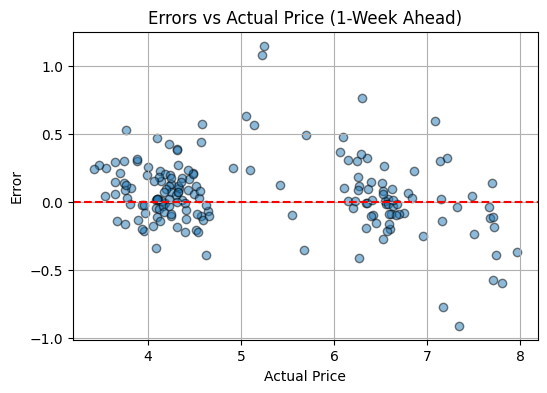

In [136]:
plt.figure(figsize=(6,4))
plt.scatter(true_next, errors_next, alpha=0.5, edgecolor='k')
plt.axhline(0, color='red', linestyle='--')
plt.title("Errors vs Actual Price (1-Week Ahead)")
plt.xlabel("Actual Price")
plt.ylabel("Error")
plt.grid(True)
plt.show()

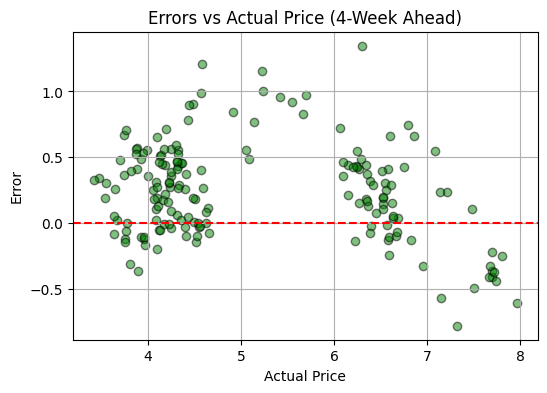

In [137]:
plt.figure(figsize=(6,4))
plt.scatter(true_4, errors_4, alpha=0.5, edgecolor='k', color='green')
plt.axhline(0, color='red', linestyle='--')
plt.title("Errors vs Actual Price (4-Week Ahead)")
plt.xlabel("Actual Price")
plt.ylabel("Error")
plt.grid(True)
plt.show()

In [138]:
import scipy.stats as stats
import numpy as np

def error_stats(errors):
    return {
        "MAE": np.mean(np.abs(errors)),
        "RMSE": np.sqrt(np.mean(errors**2)),
        "Bias (Mean Error)": np.mean(errors),
        "Std Dev": np.std(errors),
        "Skewness": stats.skew(errors),
        "Kurtosis": stats.kurtosis(errors)
    }

print("1-Week Ahead Error Stats:", error_stats(errors_next))
print("4-Week Ahead Error Stats:", error_stats(errors_4))

1-Week Ahead Error Stats: {'MAE': np.float64(0.18803249980381553), 'RMSE': np.float64(0.2689235241411708), 'Bias (Mean Error)': np.float64(0.05288729760306226), 'Std Dev': np.float64(0.2636717572830886), 'Skewness': np.float64(0.406717505527511), 'Kurtosis': np.float64(3.3657657930264238)}
4-Week Ahead Error Stats: {'MAE': np.float64(0.3461821200779506), 'RMSE': np.float64(0.4375742645451003), 'Bias (Mean Error)': np.float64(0.24179125050136024), 'Std Dev': np.float64(0.3647029314019478), 'Skewness': np.float64(0.15071489281594017), 'Kurtosis': np.float64(0.24572607556405135)}


In [139]:
actual_dir_next = (true_next[1:] > true_next[:-1]).astype(int)
pred_dir_next   = (pred_next[1:] > true_next[:-1]).astype(int)
actual_dir_4 = (true_4[1:] > true_4[:-1]).astype(int)
pred_dir_4   = (pred_4[1:] > true_4[:-1]).astype(int)

In [140]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error

def forecast_metrics(y_true, y_pred, eps=1e-8):
    y_true = np.asarray(y_true).reshape(-1)
    y_pred = np.asarray(y_pred).reshape(-1)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae  = mean_absolute_error(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / (np.abs(y_true) + eps)))
    return {"RMSE": rmse, "MAE": mae, "MAPE": mape}

# Example for 1-week ahead
metrics_1w = forecast_metrics(true_next, pred_next)

# Optional for 4-week ahead
metrics_4w = forecast_metrics(true_4, pred_4)

print("1-week ahead forecast metrics:", metrics_1w)
print("4-week ahead forecast metrics:", metrics_4w)


1-week ahead forecast metrics: {'RMSE': np.float64(0.2689235241411708), 'MAE': 0.18803249980381553, 'MAPE': np.float64(0.0369026344825858)}
4-week ahead forecast metrics: {'RMSE': np.float64(0.4375742645451003), 'MAE': 0.3461821200779506, 'MAPE': np.float64(0.06986962901855104)}


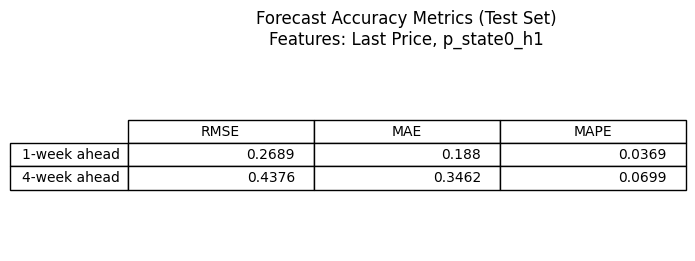

In [141]:
import matplotlib.pyplot as plt
results_df = pd.DataFrame.from_dict(
    {
        "1-week ahead": metrics_1w,
        "4-week ahead": metrics_4w
    },
    orient="index"
)

results_df

fig, ax = plt.subplots(figsize=(6, 2.5))
ax.axis("off")

table = ax.table(
    cellText=np.round(results_df.values, 4),
    colLabels=results_df.columns,
    rowLabels=results_df.index,
    loc="center"
)

table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1.2, 1.4)

feature_label = ", ".join(features_hmm)

plt.title(
    f"Forecast Accuracy Metrics (Test Set)\nFeatures: {feature_label}",
    pad=10
)


plt.show()


In [142]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

def print_direction_metrics(actual, predicted, label):
    print(f"\n=== {label} Directional Metrics ===\n")
    print("Accuracy:", accuracy_score(actual, predicted))
    print("\nClassification Report:\n", classification_report(actual, predicted))
    print("\nConfusion Matrix:\n", confusion_matrix(actual, predicted))
print_direction_metrics(actual_dir_next, pred_dir_next, "Next-Week")
print_direction_metrics(actual_dir_4, pred_dir_4, "4-Week Ahead")


=== Next-Week Directional Metrics ===

Accuracy: 0.4885057471264368

Classification Report:
               precision    recall  f1-score   support

           0       0.51      0.41      0.45        90
           1       0.48      0.57      0.52        84

    accuracy                           0.49       174
   macro avg       0.49      0.49      0.49       174
weighted avg       0.49      0.49      0.49       174


Confusion Matrix:
 [[37 53]
 [36 48]]

=== 4-Week Ahead Directional Metrics ===

Accuracy: 0.4885057471264368

Classification Report:
               precision    recall  f1-score   support

           0       0.52      0.25      0.34        91
           1       0.48      0.75      0.58        83

    accuracy                           0.49       174
   macro avg       0.50      0.50      0.46       174
weighted avg       0.50      0.49      0.46       174


Confusion Matrix:
 [[23 68]
 [21 62]]


In [143]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import pandas as pd
import numpy as np

def directional_metrics_table(actual, predicted):
    return {
        "Accuracy": accuracy_score(actual, predicted),
        "Precision (Up)": precision_score(actual, predicted, zero_division=0),
        "Recall (Up)": recall_score(actual, predicted, zero_division=0),
        "F1-score (Up)": f1_score(actual, predicted, zero_division=0),
    }

dir_results = pd.DataFrame.from_dict(
    {
        "1-week ahead": directional_metrics_table(actual_dir_next, pred_dir_next),
        "4-week ahead": directional_metrics_table(actual_dir_4, pred_dir_4),
    },
    orient="index"
)

dir_results


,Accuracy,Precision (Up),Recall (Up),F1-score (Up)
1-week ahead,0.488506,0.475248,0.571429,0.518919
4-week ahead,0.488506,0.476923,0.746988,0.582160


##Trading strategy

In [144]:
# Compute test-set actual price changes
true_test_prices = true_next.flatten()     # TRUE prices on test set
pred_test_prices = pred_next.flatten()     # PREDICTED prices on test set

# Direction: 1 = up, 0 = down
actual_dir = (true_test_prices[1:] > true_test_prices[:-1]).astype(int)
pred_dir   = (pred_test_prices[1:] > true_test_prices[:-1]).astype(int)

# Convert to trading signals
signal = np.where(pred_dir == 1, 1, -1)   # long if predict up, short if predict down
# true returns (based only on test set)
returns = (true_test_prices[1:] - true_test_prices[:-1]) / true_test_prices[:-1]
strategy_returns = signal * returns
#bechmark is long only
buy_hold_returns = returns   # always long
# Cumulative performance
cum_strategy = (1 + strategy_returns).cumprod()
cum_buy_hold = (1 + buy_hold_returns).cumprod()

In [145]:
def performance_stats(returns):
    # cumulative returns
    cum = np.cumprod(1 + returns)

    # compute drawdown using numpy
    running_max = np.maximum.accumulate(cum)
    drawdown = 1 - cum / running_max
    max_dd = np.max(drawdown)

    return {
        "Total Return": cum[-1] - 1,
        "Mean Return": np.mean(returns),
        "Std Dev": np.std(returns),
        "Sharpe (no RF)": np.mean(returns) / np.std(returns) if np.std(returns) != 0 else np.nan,
        "Max Drawdown": max_dd
    }
strategy_stats = performance_stats(strategy_returns)
bh_stats       = performance_stats(buy_hold_returns)

print("=== Strategy Performance ===")
print(strategy_stats)

print("\n=== Buy & Hold Performance ===")
print(bh_stats)



=== Strategy Performance ===
{'Total Return': np.float64(-0.19283695479653495), 'Mean Return': np.float64(-0.0006763635689313668), 'Std Dev': np.float64(0.0329891422622873), 'Sharpe (no RF)': np.float64(-0.020502611542724942), 'Max Drawdown': np.float64(0.5693014391546816)}

=== Buy & Hold Performance ===
{'Total Return': np.float64(-0.42817294281729446), 'Mean Return': np.float64(-0.002656796373979686), 'Std Dev': np.float64(0.0328889405105427), 'Sharpe (no RF)': np.float64(-0.08078084403868341), 'Max Drawdown': np.float64(0.5703517587939697)}


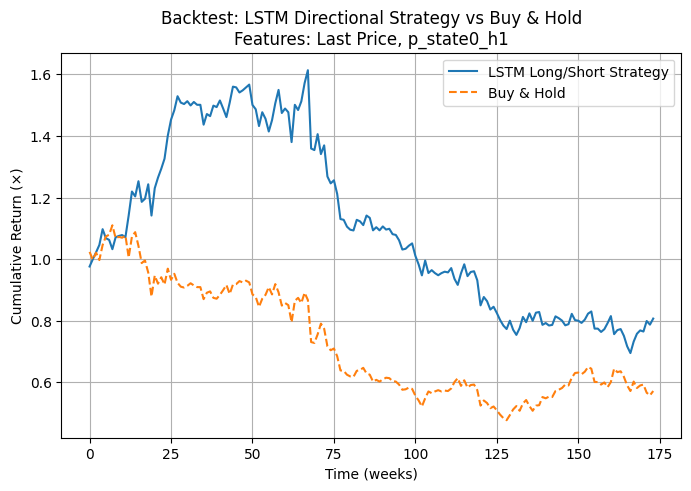

In [146]:
feature_label = ", ".join(features_hmm)


plt.figure(figsize=(8,5))
plt.plot(cum_strategy, label="LSTM Long/Short Strategy")
plt.plot(cum_buy_hold, label="Buy & Hold", linestyle='--')

plt.title(
    f"Backtest: LSTM Directional Strategy vs Buy & Hold\n"
    f"Features: {feature_label}"
)

plt.xlabel("Time (weeks)")
plt.ylabel("Cumulative Return (×)")
plt.legend()
plt.grid(True)
plt.show()
